<a href="https://colab.research.google.com/github/SSInimgba/NLP/blob/master/Covid_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Task 2 - Data Science

Clean and prepare the data for statistical analysis.
- Perform visualizations and statistical analysis on the data, showing the intrinsic statistical properties of the key features of the data set 
- What insights can you get from the dataset? Be creative as much as possible.


Develop a prediction model using the following classifiers
- Logistic Regression
- LSTM


In [ ]:
! pip install bayesian-optimization &> /dev/null

In [ ]:
!python -m spacy download en_core_web_lg &> /dev/null


In [ ]:
!pip install wikipedia &> /dev/null

In [ ]:
!pip install country_converter --upgrade &> /dev/null

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import wikipedia
import time
import country_converter as coco
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import (OneHotEncoder, MinMaxScaler, LabelEncoder)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import (cross_val_score, cross_validate)
from sklearn.metrics import (accuracy_score, classification_report)
from bayes_opt import BayesianOptimization
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
%matplotlib inline

# Global Parameters
nlp = spacy.load('en_core_web_lg')
nltk.download('popular')
stop_words = set(stopwords.words('english'))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/NB/Corona_NLP_train.csv', engine='python', encoding='latin-1')
test = pd.read_csv('/content/drive/MyDrive/NB/Corona_NLP_test.csv', engine='python', encoding='latin-1')

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
# combine dataset to perform cleaning and preprocessing 
data = pd.concat([train, test])
data = data.infer_objects()
len(data)

44955

In [ ]:
# create indexes 
categorical_columns = data.select_dtypes('object').columns.tolist()
numerical_columns = data.select_dtypes(np.number).columns.tolist()
duplicate_rows = sum(data.duplicated())

In [ ]:
# Data Summary 

print(f'There are {len(train)} tweets in the train dataset and {len(test)} tweets in the test dataset ')
print(f'There are {len(categorical_columns)} categorical descriptors and {len(numerical_columns)} numerical descriptors')
print(f'There are {duplicate_rows} duplicates in the dataset')

There are 41157 tweets in the train dataset and 3798 tweets in the test dataset 
There are 4 categorical descriptors and 2 numerical descriptors
There are 0 duplicates in the dataset


In [ ]:
# let's fix the data types i.e change TweetAt to datetime object
print(f" Before transformation \n")
print(f" {data['TweetAt'].dtype} \n")
pd.to_datetime(data['TweetAt'], format='%d-%m-%Y', errors='coerce') 
print(f" After transformation \n")
print(f" {data['TweetAt'].dtype}")

 Before transformation 

 object 

 After transformation 

 object


In [ ]:
data['TweetAt'].head()

0    16-03-2020
1    16-03-2020
2    16-03-2020
3    16-03-2020
4    16-03-2020
Name: TweetAt, dtype: object

In [ ]:
# check for null columns 

percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_df = pd.DataFrame({'column_name': data.columns, 'null_amount': data.isnull().sum(), 'percent_missing': percent_missing})
missing_value_df

column_name  null_amount  percent_missing
UserName            UserName            0         0.000000
ScreenName        ScreenName            0         0.000000
Location            Location         9424        20.963185
TweetAt              TweetAt            0         0.000000
OriginalTweet  OriginalTweet            0         0.000000
Sentiment          Sentiment            0         0.000000

The location feature has 9424 missing data which makes up about 21% of the data in that column. We need to decide how to handle this, either filling with the most common or dropping the null rows.

 ##  **EDA Univariate and Multivariate Analysis**



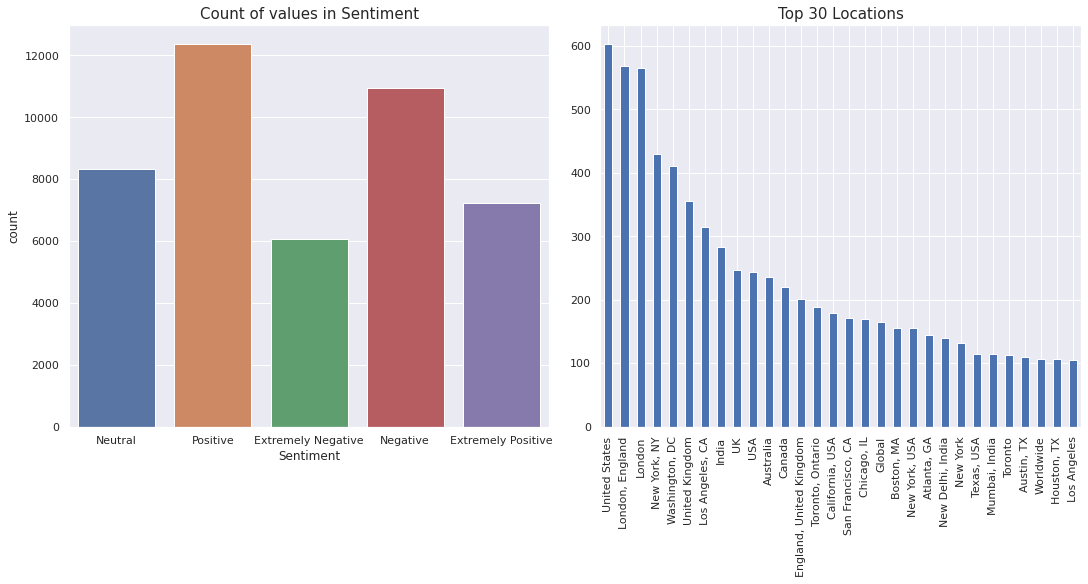

In [ ]:
sns.set(font_scale=1)

total_cols = 2
total_rows = 1

fig, axes = plt.subplots(nrows=total_rows, ncols=total_cols,  figsize=(15, 8), constrained_layout=True, squeeze=False )
fig_one = sns.countplot(x='Sentiment', data=data, ax=axes[0][0]) 
fig_one.set_title(f'Count of values in Sentiment', fontsize= 15)
fig_two = data['Location'].value_counts().head(30).plot(kind='bar', ax=axes[0][1])
fig_two.set_title(f'Top 30 Locations', fontsize= 15)

plt.show()


**Sentiment:** 
- We can observe 5 different categories to describe the sentiments. Ranging from Extremely Negative to Extremely Positive. Positive tweets have the highest representaion than their negative counterparts i.e Positive > Negative and Extremely Positive > Extremely Negative 

**Location:** 
- We plot only the top 30 Locations in the dataset. Location data seems to be in various formats i.e Country (United States) or City (London) or a combination (New Dehli, India) of it. This let's us know that this column contains self reported locations or bios and therefore would need to be cleaned further for proper analysis.  This may also explain the null values in this column as most twitter accounts do not report their locations. By countries, we can see that USA, UK, INDIA, AUSTRALIA, CANADA are the top countries 


### What Country holds the most share in sentiments 

In [ ]:
pd.crosstab(data['Sentiment'], data[ 'Location']).sort_values('Location', ascending=False)

Location                     Texas    170825 ? shinee ? svt ? vixx  \
Sentiment                                                            
Neutral             2            0                               0   
Extremely Negative  0            0                               0   
Extremely Positive  0            1                               0   
Negative            2            0                               0   
Positive            1            0                               1   

Location              UK to Detroit Worldwide    VA - TX - ??- Belgium??  \
Sentiment                                                                  
Neutral                                     0                          1   
Extremely Negative                          0                          0   
Extremely Positive                          0                          0   
Negative                                    1                          0   
Positive                                    0                          0   

Location             #Australia #Oceania   #LeafsNation ??  \
Sentiment                                                    
Neutral                                0                 0   
Extremely Negative                     0                 0   
Extremely Positive                     0                 1   
Negative                               1                 0   
Positive                               0                 0   

Location             #Newyork USA #America   +254 (Kenya)  \
Sentiment                                                   
Neutral                                  1              0   
Extremely Negative                       0              0   
Extremely Positive                       0              1   
Negative                                 0              0   
Positive                                 0              0   

Location             2105 Bridge City, Texas 77611  \
Sentiment                                            
Neutral                                          0   
Extremely Negative                               0   
Extremely Positive                               1   
Negative                                         0   
Positive                                         0   

Location             33 Main St, Buncrana, Donegal  \
Sentiment                                            
Neutral                                          0   
Extremely Negative                               0   
Extremely Positive                               0   
Negative                                         1   
Positive                                         0   

Location             75, 12th Street, Parkhurst   ?   ? ??? ?t ?? l???? ?t ??  \
Sentiment                                                                       
Neutral                                       0   0                         0   
Extremely Negative                            0   0                         4   
Extremely Positive                            0   0                         0   
Negative                                      1   1                         1   
Positive                                      0   0                         0   

Location             ? Salford ?   ??   ?? ???? ??? ????? ???????   \
Sentiment                                                            
Neutral                        1    0                            0   
Extremely Negative             0    1                            0   
Extremely Positive             0    0                            0   
Negative                       0    0                            0   
Positive                       0    1                            1   

Location             ?? Silicon Valley    ?? UAE | ???? ????  \
Sentiment                                                      
Neutral                               0                    0   
Extremely Negative                    1                    0   
Extremely Positive                    0 

The location data is very messy and sparse

In [ ]:
# compress analysis to only include locations with greater than 100 occurences

sub_df = data[data.groupby('Location')['Location'].transform('size') > 100]
sub_df['Location'].value_counts()


United States              603
London, England            568
London                     565
New York, NY               429
Washington, DC             411
United Kingdom             355
Los Angeles, CA            314
India                      283
UK                         246
USA                        243
Australia                  236
Canada                     220
England, United Kingdom    201
Toronto, Ontario           189
California, USA            179
San Francisco, CA          171
Chicago, IL                170
Global                     164
Boston, MA                 156
New York, USA              156
Atlanta, GA                145
New Delhi, India           140
New York                   132
Texas, USA                 115
Mumbai, India              114
Toronto                    112
Austin, TX                 109
Worldwide                  107
Houston, TX                107
Los Angeles                105
London, UK                 102
Lagos, Nigeria             101
Name: Lo

In [ ]:
# We need to clean the location data for further analysis 
sub_df['Location'] = sub_df['Location'].astype('str')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# Discretisize the Location 

conditions = [sub_df['Location']=='London',
              sub_df['Location']=='UK',
              sub_df['Location']=='London, England',
              sub_df['Location']=='United Kingdom',
              sub_df['Location']=='England, United Kingdom',
              sub_df['Location']=='London, UK',
              sub_df['Location']=='Chicago, IL',
              sub_df['Location']=='New York, NY',
              sub_df['Location']=='United States',
              sub_df['Location']=='Washington, DC',
              sub_df['Location']=='Boston, MA',
              sub_df['Location']=='Houston, TX',
              sub_df['Location']=='USA',
              sub_df['Location']=='Los Angeles, CA',
              sub_df['Location']=='California, USA',
              sub_df['Location']=='San Francisco, CA',
              sub_df['Location']=='New York',
              sub_df['Location']=='Texas, USA',
              sub_df['Location']=='New York, USA',
              sub_df['Location']=='Atlanta, GA',
              sub_df['Location']=='Austin, TX',
              sub_df['Location']=='Los Angeles',
              sub_df['Location']=='Canada',
              sub_df['Location']=='Toronto',
              sub_df['Location']=='Toronto, Ontario',
              sub_df['Location']=='India',
              sub_df['Location']=='Mumbai, India',
              sub_df['Location']=='New Delhi, India',
              sub_df['Location']=='Australia',
              sub_df['Location']=='Lagos, Nigeria',
              sub_df['Location']=='Worldwide',
              sub_df['Location']=='Global']

 
country = ['UK','US','CANADA','INDIA','AUSTRALIA','NIGERIA','OTHERS'] 
country_count = [6,16,3,3,1,1,2]
outputs = sum([[s] * n for s, n in zip(country, country_count)], [])

sub_df['Country'] = np.select(conditions, outputs, default=np.nan)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
ct = pd.crosstab(sub_df['Sentiment'], sub_df['Country'])

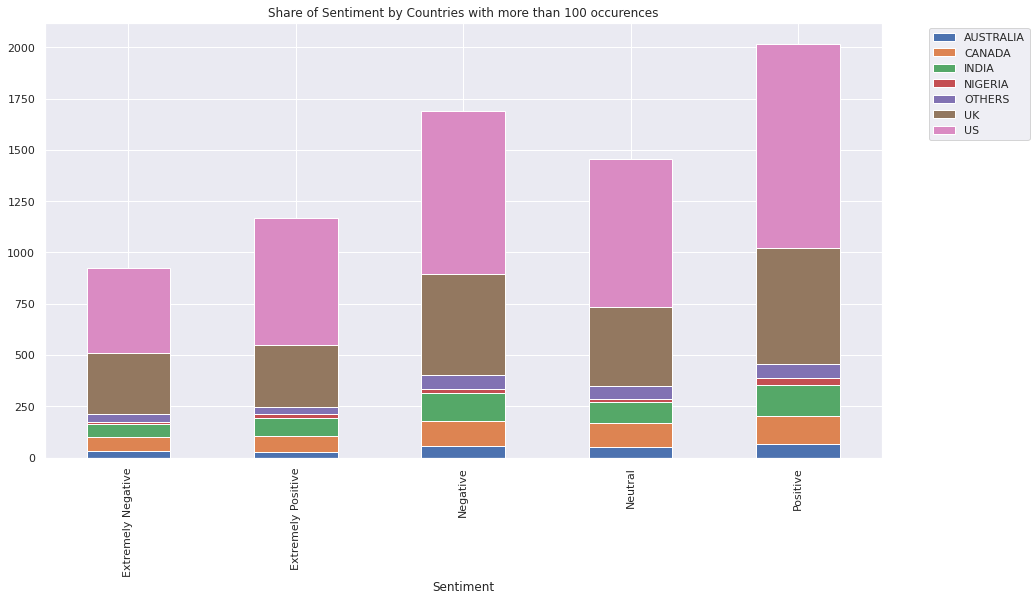

In [ ]:
ct.plot.bar(stacked=True, figsize=(15,8));
plt.title('Share of Sentiment by Countries with more than 100 occurences');
plt.legend(bbox_to_anchor=(1.05, 1));


## Preprocess Tweets

In [ ]:
data[['OriginalTweet']].sample(10)

OriginalTweet
35550                                                                                                                                                                                                                                Petrol diesel prices stagnant for 24th consecutive amid COVID 19 lockdown Key things to know
40827             iLifeMedical is supplying high-quality certified PPE products (COVID-19 Test Kits, N95 Masks, Gloves, Surgical Mask, Goggles, Ventilators and Other Supplies) in large quantities, quickly, and at reasonable prices. Order Now at https://t.co/e60Vx3PNoa #testkits #kn95mask #COVID19 https://t.co/5Cy8y66K8X
14997                                                                                                          The "Roaring 20's" has brought #Covid_19 illness, a stock market nose-dive, job losses, a possible depression, and a climate change induced global upheavel in food security, home safety, and travel.\r\r\nYay. ?
18247  A massive thank you to @AldiUK ????\r\r\n\r\r\nThanks for sticking to the 4 items limit. And your excellent staff.\r\r\n\r\r\nIn your own way. You are saving lives too.\r\r\n\r\r\nThis is why I love #Aldi\r\r\nOn both sides of the Atlantic. Not just for the prices.\r\r\n#StayAtHomeSaveLives #COVID?19 #coronavirus
3246                                                                If every retail, fast food &amp; convenience store chain that's emailed me to describe how they're providing or extending their sick leave policies would make those changes permanent, I'll call that the #COVID19 silver lining. #PaidSickDays #coronavirus
11752                  Panicked #wealthy fleeing the #coronavirus drive up rental prices in the #Hamptons &amp; #HudsonValley\r\r\nHomes that would typically rent for $4,000 a month during the winter and spring are now going for up to $18,000 the month.\r\r\nhttps://t.co/gMu1UfUA7x\r\r\n#CoronavirusNY #COVID #TaxTheRich
31545                                                                                                                                                                                                                                                  COVID 19 Why hoarding supplies is human nature according to a psychologist
4185                                                                                                                                                                                 Great idea to get shops to allow online shopping for community through community accounts and order bigger amounts do they can distribute 19
36998                                                                                                                                                                                                                         Tesco says U.K. supply chain critical in Covid-19 - https://t.co/6sSxzOCPjx https://t.co/SCyLjwgLZg
27522                                                                                                                                                                                             "The thing about panic-buying is that it gives us a sense of control at a time when we're lacking that" https://t.co/rafvJ2PWVO

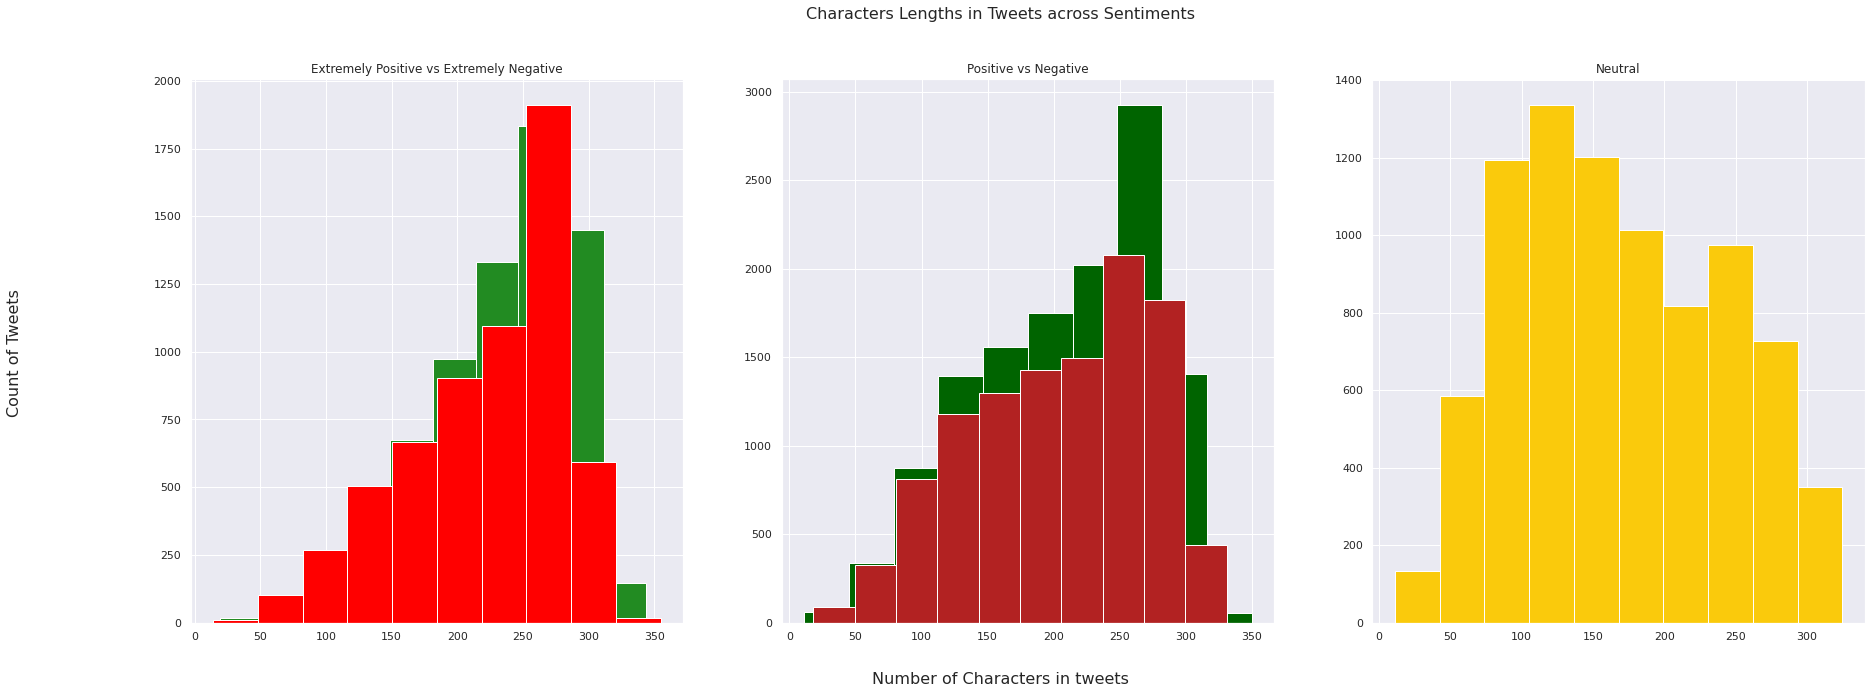

In [ ]:
fig,(ax1, ax2, ax3)= plt.subplots(1,3,figsize=(30,10))


tweet_len=data[data['Sentiment']=="Extremely Positive"]['OriginalTweet'].str.len()
ax1.hist(tweet_len,color='#228B22')
tweet_len=data[data['Sentiment']=="Extremely Negative"]['OriginalTweet'].str.len()
ax1.hist(tweet_len, color='#FF0000')
ax1.set_title('Extremely Positive vs Extremely Negative')


tweet_len=data[data['Sentiment']=="Positive"]['OriginalTweet'].str.len()
ax2.hist(tweet_len, color='#006400')
tweet_len=data[data['Sentiment']=="Negative"]['OriginalTweet'].str.len()
ax2.hist(tweet_len, color='#B22222')
ax2.set_title('Positive vs Negative')


tweet_len=data[data['Sentiment']=="Neutral"]['OriginalTweet'].str.len()
ax3.hist(tweet_len, color='#FACA0C')
ax3.set_title('Neutral')


fig.suptitle('Characters Lengths in Tweets across Sentiments', fontsize=16)
fig.text(0.5, 0.04, 'Number of Characters in tweets', ha='center', fontsize=16)
fig.text(0.04, 0.5, 'Count of Tweets', va='center', rotation='vertical', fontsize=16)

plt.show()

**Extremeley Positive vs Extremely Negative tweets:**
  - Tweets with or greater than 300 character lengths have a higher proportion of extremely positive sentiments expressed than extremely negative sentiments expressed. 

**Positive vs Negative tweets:**
- Tweets with or greater than 100 character lengths have a higher proportion of positive sentiments expressed than negative sentiments expressed. 



In [ ]:
# make a copy of the data
data_preprocessed = data 

In [ ]:
def find_hashtags(tweet):
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)  


def count_hashtags(hashtags):
    return len(hashtags)

In [ ]:
data_preprocessed['hashtags'] = data_preprocessed.OriginalTweet.apply(find_hashtags)
data_preprocessed['hashtags_count'] = data_preprocessed['hashtags'].apply(count_hashtags)

In [ ]:
extremely_positive_df = data_preprocessed[data_preprocessed['Sentiment'] == 'Extremely Positive']
extremely_negative_df = data_preprocessed[data_preprocessed['Sentiment'] == 'Extremely Negative']
positive_df = data_preprocessed[data_preprocessed['Sentiment'] == 'Positive']
negative_df = data_preprocessed[data_preprocessed['Sentiment'] == 'Negative']
neutral_df = data_preprocessed[data_preprocessed['Sentiment'] == 'Neutral']

In [ ]:
# create dataframe where each use of hashtag gets its own row

def popular_hastags(df):
  flattened_hashtags_df = pd.DataFrame([hashtag for hashtags_list in df.hashtags for hashtag in hashtags_list], columns=['hashtag'])
  # number of unique hashtags
  numberuniquehashtags = flattened_hashtags_df['hashtag'].unique().size
  # count of appearances of each hashtag
  popular_hashtags = flattened_hashtags_df.groupby('hashtag').size().reset_index(name='counts').sort_values('counts', ascending=False).reset_index(drop=True)
  return popular_hashtags


In [ ]:
popular_hashtags_expos = popular_hastags(extremely_positive_df)
popular_hashtags_exneg = popular_hastags(extremely_negative_df)
popular_hashtags_pos = popular_hastags(positive_df)
popular_hashtags_neg = popular_hastags(negative_df)
popular_hashtags_neu = popular_hastags(neutral_df)

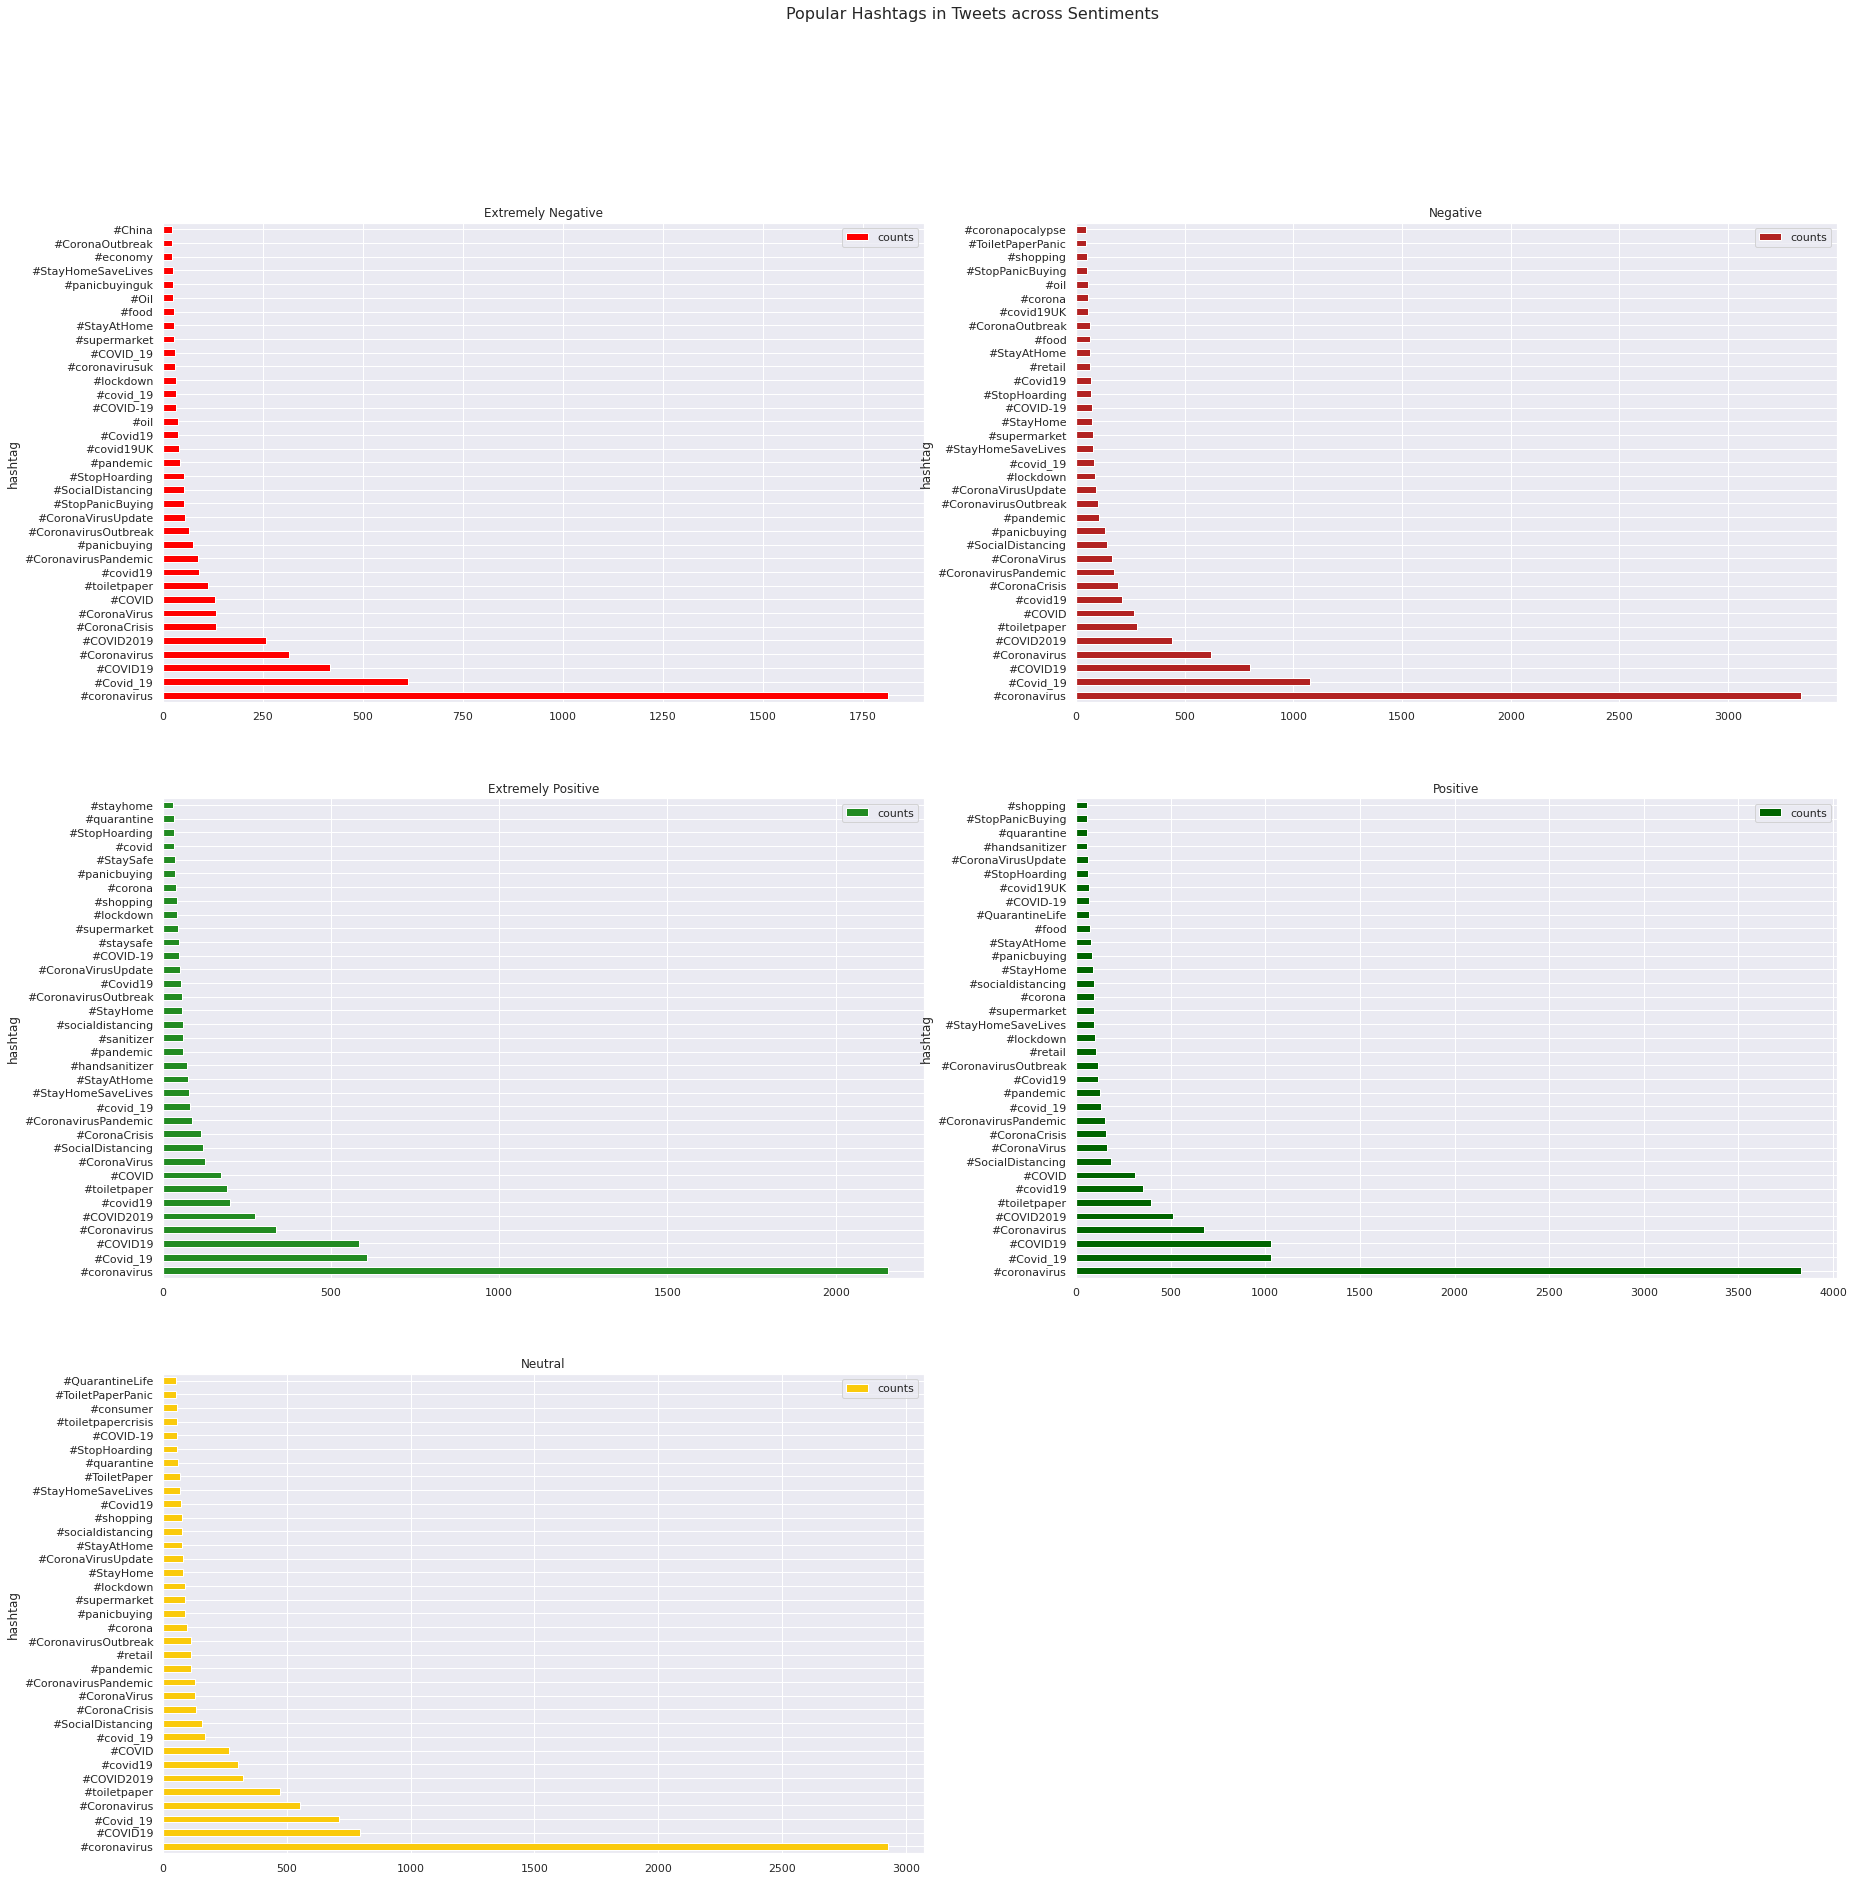

In [ ]:
fig, ax = plt.subplots(3,2, figsize=(30,30))

popular_hashtags_exneg.head(35).plot.barh(x='hashtag', y='counts', color='#FF0000', ax = ax[0][0])
ax[0][0].set_title('Extremely Negative')

popular_hashtags_neg.head(35).plot.barh(x='hashtag', y='counts', color='#B22222', ax = ax[0][1])
ax[0][1].set_title('Negative')

popular_hashtags_expos.head(35).plot.barh(x='hashtag', y='counts', color='#228B22', ax = ax[1][0])
ax[1][0].set_title('Extremely Positive')

popular_hashtags_pos.head(35).plot.barh(x='hashtag', y='counts', color='#006400', ax = ax[1][1])
ax[1][1].set_title('Positive')

popular_hashtags_neu.head(35).plot.barh(x='hashtag', y='counts', color='#FACA0C', ax = ax[2][0])
ax[2][0].set_title('Neutral')

fig.delaxes(ax= ax[2,1]) 

fig.suptitle('Popular Hashtags in Tweets across Sentiments', fontsize=16)

plt.show()

The sentiments all share very similar hastags which relate to reactions to the pandemic. 

**Extremely Negative tweets vs Negative tweets:**
  - We can see that China is seen in extremely negative tweets versus in negative tweets. This is possibly due to reactions concerning China's role in the pandemic





#  **Modelling and Evaluation**

In [ ]:
# Discretisize the target class into 3 i.e Negative, Positive and Neutral

conditions = [data['Sentiment']=='Positive',
              data['Sentiment']=='Extremely Positive',
              data['Sentiment']=='Negative',
              data['Sentiment']=='Extremely Negative',
              data['Sentiment']=='Neutral',]

 
outputs = [1,1,0,0,2] 

data_preprocessed['Sentiment']= np.select(conditions, outputs, default=np.nan)

1.0    0.435814
0.0    0.378846
2.0    0.185341
Name: Sentiment, dtype: float64

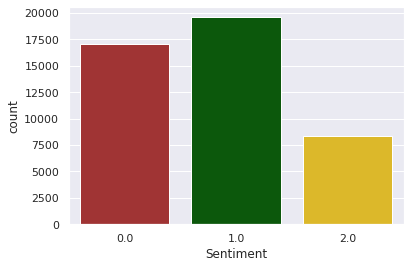

In [ ]:
sns.countplot(x='Sentiment', data=data_preprocessed, palette = ['#B22222', '#006400', '#FACA0C']);
data_preprocessed['Sentiment'].value_counts(normalize=True)

By discretizing the target class into 3 categories, we observe new volumes. There is a slight imbalance with the neutral category, however it is not too severe. 

In [ ]:
# Define preprocessing functions 


def preprocess_tweet_text(tweet):
  """
  This function take in the tweet data and normalizes it by transforming it to lowercase,
  removing urls, removing hashtags and @, removing punctuations, stopwords and 
  finally lemmatizing the words
  """
  tweet = tweet.lower()
  # Remove urls
  tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
  # Remove user @ references and '#' from tweet
  tweet = re.sub(r'\@\w+|\#','', tweet)
  # Remove punctuations
  tweet = tweet.translate(str.maketrans('', '', string.punctuation))
  # Remove stopwords
  tweet_tokens = word_tokenize(tweet)
  covi = 'covi'
  corona = 'corona'
  corona_words = list(set([w for w in tweet_tokens if w.lower().startswith(covi) or w.lower().startswith(corona)]))
  #add words that aren't in the NLTK stopwords list
  new_stopwords_list = stop_words.union(corona_words)
  filtered_words = [w for w in tweet_tokens if not w in new_stopwords_list]
  # Lemmatize words
  lemmatizer = WordNetLemmatizer()
  lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in filtered_words]
  return " ".join(filtered_words)


def get_feature_vector(data):
  """
  Converts the tokenized data into numerical represenation
  """
  vector = TfidfVectorizer(sublinear_tf=True)
  vector.fit(data)
  return vector

In [ ]:
# preprocess data 

X = data_preprocessed['OriginalTweet'].apply(preprocess_tweet_text)
tf_vector = get_feature_vector(np.array(X).ravel())
X = tf_vector.transform(np.array(X).ravel())

In [ ]:
y = np.array(data_preprocessed['Sentiment']).ravel()
y

array([2., 1., 1., ..., 2., 0., 1.])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=8)
print(f"X train: {X_train.shape}, X test: {X_test.shape},\ny train: {y_train.shape}, y test: {y_test.shape}")

X train: (30119, 54508), X test: (14836, 54508),
y train: (30119,), y test: (14836,)


In [ ]:
# Training Logistics Regression model
lr = LogisticRegression(max_iter=300, C = 1, penalty='l2')
lr

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=300,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
lr.fit(X_train, y_train)
y_predict_lr = lr.predict(X_test)

In [ ]:
lr_acc = accuracy_score(y_test, y_predict_lr)
print(f" Logistic regression Test Accuracy: {lr_acc}")

 Logistic regression Test Accuracy: 0.7993394445942302


In [ ]:
def lrc(C):
  """
  Objective funtion to be optimized by Bayesian optimization.
  This function returns the cross validation score of the model and takes in the model parameters to be tuned
  """
  params={"max_iter": 500, "C": float(C)}

  # Define the pipeline
  model = LogisticRegression(**params)
  cv_result = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=5)
  return np.mean(cv_result)

In [ ]:
lrcBO = BayesianOptimization(lrc, {"C": (10, 0.1)}, random_state=42)

lrcBO.maximize(n_iter=10, init_points=2)

|   iter    |  target   |     C     |
-------------------------------------
|  1        |  0.774    |  6.292    |
|  2        |  0.7878   |  0.5879   |
|  3        |  0.7807   |  0.1      |
|  4        |  0.7807   |  0.1      |
|  5        |  0.7807   |  0.1      |
|  6        |  0.7807   |  0.1      |
|  7        |  0.7807   |  0.1      |
|  8        |  0.7807   |  0.1      |
|  9        |  0.7807   |  0.1      |
|  10       |  0.7807   |  0.1      |
|  11       |  0.7807   |  0.1      |
|  12       |  0.7807   |  0.1      |


Parameter tuning using Bayesian optimiztaion did not improve performance

In [ ]:
print(classification_report(y_test, y_predict_lr,target_names = ['Negative','Positive', 'Neutral'] ))

              precision    recall  f1-score   support

    Negative       0.81      0.80      0.81      5618
    Positive       0.85      0.83      0.84      6507
     Neutral       0.68      0.72      0.70      2711

    accuracy                           0.80     14836
   macro avg       0.78      0.78      0.78     14836
weighted avg       0.80      0.80      0.80     14836



## LSTM

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# preprocess data  for LSTM
X_cleaned = data_preprocessed['OriginalTweet'].apply(preprocess_tweet_text)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_cleaned)
X_lstm = tokenizer.texts_to_sequences(X_cleaned) #convert to integer sequence
word_to_ind = tokenizer.word_index #word to index dictionnary
vocabSize = len(word_to_ind)+1

In [ ]:
print(f"Vocabulary size: {vocabSize} \n")

print(f"Sample Sentence:\n{X_cleaned.values[3]}")
print(f"\nAfter tokenizing :\n{X_lstm[3]}")

X_lstm = pad_sequences(X, padding='post')
print(f"\nAfter padding :\n{X_lstm[3]}")

Vocabulary size: 55802 

Sample Sentence:
food stock one empty please dont panic enough food everyone take need stay calm stay safe confinement confinementotal confinementgeneral

After tokenizing :
[1, 17, 28, 118, 31, 63, 15, 150, 1, 59, 55, 14, 42, 744, 42, 85, 4323, 16368, 23087]

After padding :
[    1    17    28   118    31    63    15   150     1    59    55    14
    42   744    42    85  4323 16368 23087     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y, test_size=0.33, random_state=8)
print(f"X train: {X_train.shape}, X test: {X_test.shape},\ny train: {y_train.shape}, y test: {y_test.shape}")

X train: (30119, 45), X test: (14836, 45),
y train: (30119,), y test: (14836,)


In [ ]:
# hyper paramaters
epochs = 5
batch_size = 32
embed_dim = 16
units = 256

In [ ]:
model = keras.Sequential([
    layers.Embedding(vocab_size, embed_dim, input_length=X.shape[1]),
    layers.Bidirectional(layers.LSTM(units,return_sequences=True)),
    layers.GlobalMaxPool1D(),
    layers.Dropout(0.4),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(3)
])


model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam', metrics=['accuracy']
             )
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 45, 16)            892832    
_________________________________________________________________
bidirectional (Bidirectional (None, 45, 512)           559104    
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1

In [ ]:

lstm = model.fit(X_train, y_train, epochs=epochs, validation_split=0.12, batch_size=batch_size)

Epoch 1/5
829/829 [==============================] - 290s 345ms/step - loss: 0.9329 - accuracy: 0.5199 - val_loss: 0.5750 - val_accuracy: 0.7867
Epoch 2/5
829/829 [==============================] - 288s 348ms/step - loss: 0.4353 - accuracy: 0.8562 - val_loss: 0.5006 - val_accuracy: 0.8254
Epoch 3/5
829/829 [==============================] - 288s 347ms/step - loss: 0.2458 - accuracy: 0.9246 - val_loss: 0.5468 - val_accuracy: 0.8221
Epoch 4/5
829/829 [==============================] - 289s 348ms/step - loss: 0.1701 - accuracy: 0.9492 - val_loss: 0.6121 - val_accuracy: 0.8019
Epoch 5/5
829/829 [==============================] - 288s 347ms/step - loss: 0.1265 - accuracy: 0.9601 - val_loss: 0.7617 - val_accuracy: 0.7967


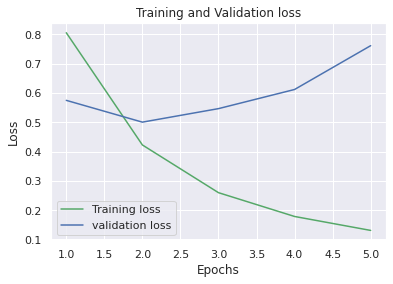

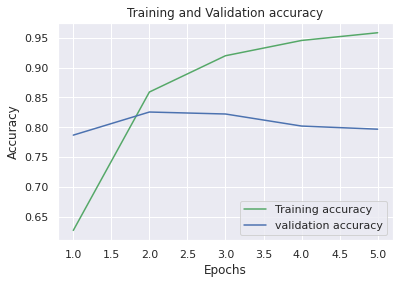

In [ ]:
loss_train = lstm.history['loss']
loss_val = lstm.history['val_loss']
epochs = range(1,6)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


loss_train = lstm.history['accuracy']
loss_val = lstm.history['val_accuracy']
epochs = range(1,6)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Past 2 epochs and the model starts overfitting

In [ ]:
#tf.keras.backend.clear_session()
lstm = model.fit(X_train, y_train, epochs=2, validation_split=0.12, batch_size=batch_size)

Epoch 1/2
829/829 [==============================] - 288s 343ms/step - loss: 0.9092 - accuracy: 0.5233 - val_loss: 0.5306 - val_accuracy: 0.8097
Epoch 2/2
829/829 [==============================] - 283s 341ms/step - loss: 0.4018 - accuracy: 0.8693 - val_loss: 0.4945 - val_accuracy: 0.8221


In [ ]:
y_pred_lstm = np.argmax(model.predict(X_test), axis=-1)

In [ ]:
loss, lstm_acc = model.evaluate(X_test,y_test,verbose=0)
print(f'LSTM Test loss: {loss}')
print(f'LSM Test Accuracy: {lstm_acc}')

LSTM Test loss: 0.482257604598999
LSM Test Accuracy: 0.8282555937767029


In [ ]:
print(classification_report(y_test, y_pred_lstm, target_names = ['Negative','Positive', 'Neutral'] ))

              precision    recall  f1-score   support

    Negative       0.82      0.82      0.82      5618
    Positive       0.83      0.89      0.86      6507
     Neutral       0.84      0.69      0.76      2711

    accuracy                           0.83     14836
   macro avg       0.83      0.80      0.81     14836
weighted avg       0.83      0.83      0.83     14836



In [ ]:
print(f'Test accuracy for LR: {lr_acc} vs LSTM {lstm_acc}')

Test accuracy for LR: 0.7993394445942302 vs LSTM 0.8282555937767029


LSTM model had a higher accuracy than the logistic regression model. Since LSTM works with sequences, while LR cannot, this gives LSTM more information than LR, and therfore makes it perform better.